# Detección de bordes

En esta clase vamos a explorar el concepto de **gradiente de imagen** y a experimentar con detectores simples de "bordes" (*edges*) y segmentos de recta. Es la base de métodos de descripción de imágenes más potentes.

## Bibliotecas y utilidades

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

from skimage.transform import probabilistic_hough_line

from scipy.signal import argrelextrema

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) #/ 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    plt.imshow(x, 'gray')

## Gradiente de la imagen

En cada pixel de la imagen hay un vector que indica la dirección hacia la que aumenta la intensidad de luz.

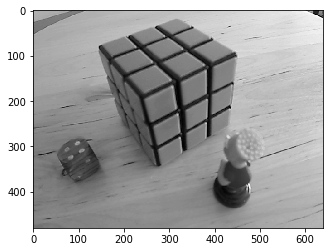

In [2]:
img = readrgb('cube3.png')
g   = gray2float(rgb2gray(img))
imshowg(g);

El gradiente se calcula normalmente tras un suavizado, para obtener los cambios de intensidad a la escala de detalle deseada.

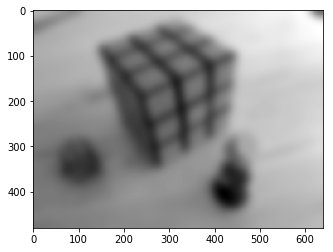

In [3]:
s = cv.GaussianBlur(g,(0,0),10)
imshowg(s)

In [4]:
def grad(x):
    gx = cv.Sobel(x,-1,1,0)/8
    gy = cv.Sobel(x,-1,0,1)/8
    return gx,gy

gx,gy = grad(s)

La máscara de Sobel produce un valor proporcional a la derivada. Dividimos por 8 para conseguir el valor real. Comprobamos el resultado que obtiene en una rampa de pendiente 1:

In [5]:
np.outer(np.arange(10),[1,1,1,1,1]).T

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [6]:
grad(np.outer(np.arange(10),[1,1,1,1,1]).T.astype(np.uint8))[0]

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.]])

Mostramos por separado una imagen con todas las componentes $\nabla_x$ y otra con todas las componentes $\nabla_y$:

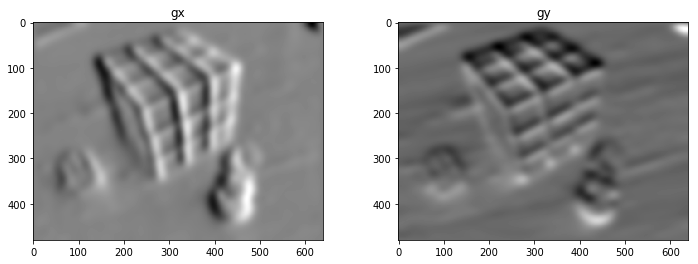

In [7]:
fig(12,4)
plt.subplot(1,2,1); imshowg(gx); plt.title('gx')
plt.subplot(1,2,2); imshowg(gy); plt.title('gy');

En gx las zonas blancas indican incremento de intensidad al movernos hacia la derecha, que es el sentido en que aumenta la coordenada "columna". En "gy" las zonas blancas indican incremento de intensidad al movernos hacia abajo, que es la dirección en la que aumenta la coordenada "fila".

Es más ilustrativo mostrar el gradiente como campo vectorial:

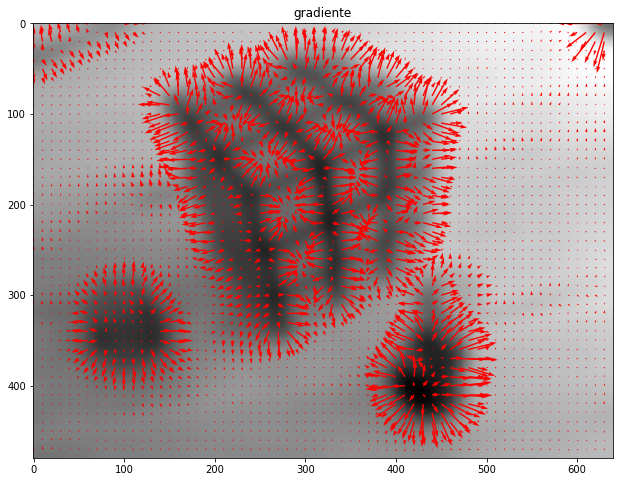

In [8]:
# para generar un "grid" con coordenadas
def dom(sz, by=1):
    r,c = sz
    x,y = np.meshgrid(range(0,c,by),range(0,r,by))
    return x,y

# saltamos de 10 en 10 para no poner demasiadas flechas en la imagen
x,y = dom(s.shape,10)

r1 = y
c1 = x
r2 = -gy[r1,c1]   # filas = - eje Y
c2 =  gx[r1,c1]

fig(12,8)
imshowg(s)
plt.quiver(c1, r1, c2, r2, color='Red');
plt.title('gradiente');

Las zonas uniformes tienen gradiente nulo, y en las zonas de pendiente pronunciada vemos que los vectores apuntan hacia las zonas más claras de la imagen.

### Gradiente en forma polar

Frecuentemente es preferible expresar el gradiente en [coordenadas polares](https://en.wikipedia.org/wiki/Polar_coordinate_system) (módulo y ángulo). Además, el ángulo se suele discretizar en un pequeño número de orientaciones.

## Bordes

Veamos en detalle los pixels de la fila 200 de la imagen (estirados en vertical para verlos mejor):

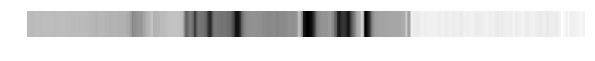

In [9]:
franja = np.zeros([30,s.shape[1]]) + g[200]
fig(10,4)

imshowg(franja); plt.axis('off');

La misma fila suavizada:

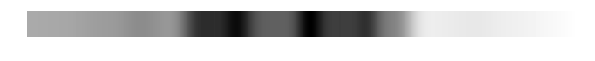

In [10]:
franja = np.zeros([30,s.shape[1]]) + s[200]
fig(10,4)

imshowg(franja); plt.axis('off');

Comparamos los perfiles de niveles de gris en esa fila.

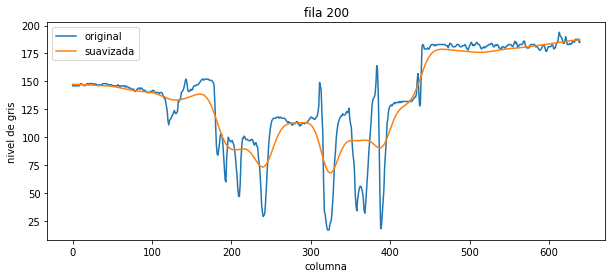

In [11]:
fig(10,4)
plt.plot(g[200],label='original');
plt.plot(s[200],label='suavizada');
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Nuestro problema es encontrar la posición precisa de los bordes teniendo en cuenta que el "escalón" de nivel de gris que observamos en la imagen puede ser bastante gradual.

Veamos la derivada de la imagen suavizada en esa fila ($\nabla_x$)

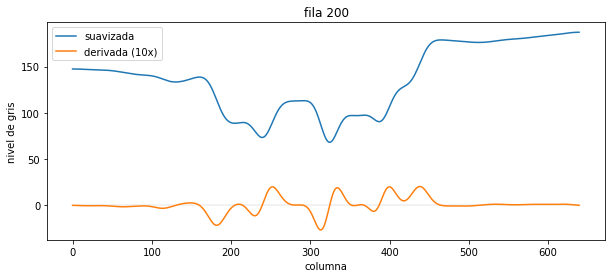

In [12]:
fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(10*gx[200],label='derivada (10x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Los extremos de la derivada ocurren en los puntos de máxima pendiente de nivel de gris, que son la mejor estimación de la posición del borde.

[149 252 334 400 438]
[113 182 230 313 380]


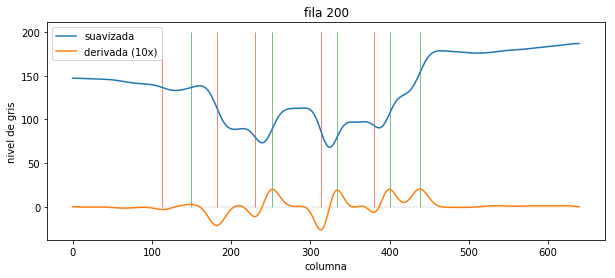

In [13]:
pix = gx[200]

THG = 0.2
edgesp = argrelextrema(pix*(pix> THG),np.greater,order=5)[0]
edgesn = argrelextrema(pix*(pix<-THG),np.less,   order=5)[0]

print(edgesp)
print(edgesn)

fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(10*gx[200],label='derivada (10x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.vlines(edgesp,ymin=0,ymax=200,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=0,ymax=200,colors='red',lw=0.5);
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

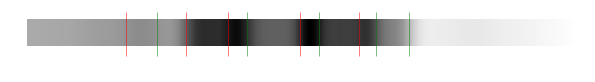

In [14]:
franja = np.zeros([30,s.shape[1]]) + s[200]
fig(10,4)

imshowg(franja); plt.axis('off');
#imshowg(grad(franja)[0]); plt.axis('off');
plt.vlines(edgesp,ymin=-10,ymax=40,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=-10,ymax=40,colors='red',lw=0.5);

Si no se suaviza la imagen, o el nivel de suavizado es muy pequeño (el operador de Sobel realiza implícitamente un suavizado leve), aparecen muchos más bordes debido al ruido de imagen o a detalles de tamaño pequeño.

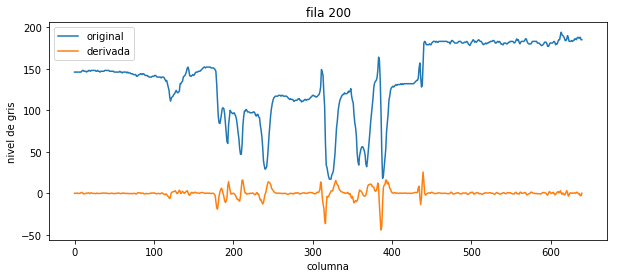

In [15]:
fig(10,4)
plt.plot(g[200],label='original');
plt.plot(grad(g)[0][200],label='derivada');
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

[132 142 185 194 212 244 310 329 359 373 382 392 439 612 620]
[120 145 180 190 208 237 316 352 386 436 596 622 637]


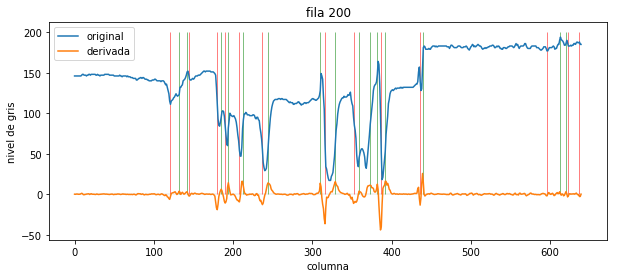

In [16]:
pix = grad(g)[0][200]

THG = 2
edgesp = argrelextrema(pix*(pix> THG),np.greater,order=5)[0]
edgesn = argrelextrema(pix*(pix<-THG),np.less,   order=5)[0]

print(edgesp)
print(edgesn)

fig(10,4)
plt.plot(g[200],label='original');
plt.plot(pix,label='derivada');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.vlines(edgesp,ymin=0,ymax=200,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=0,ymax=200,colors='red',lw=0.5);
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

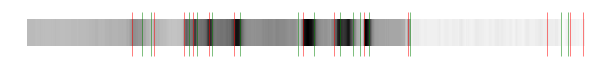

In [17]:
franja = np.zeros([30,s.shape[1]]) + g[200]
fig(10,4)

imshowg(franja); plt.axis('off');
#imshowg(grad(franja)[0]); plt.axis('off');
plt.vlines(edgesp,ymin=-10,ymax=40,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=-10,ymax=40,colors='red',lw=0.5);

La detección de bordes siempre se hace sobre un determinado nivel de suavizado o escala de detalle $\sigma$.

Veamos la segunda derivada. Sus *cruces por cero* corresponden con los extremos de primera derivada y también indican la posición de los bordes.

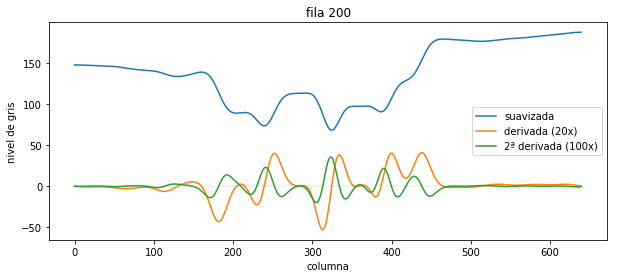

In [18]:
gxx,_ = grad(gx)

fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(20*gx[200],label='derivada (20x)');
plt.plot(100*gxx[200],label='2ª derivada (100x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Como la imagen es una función de dos variables tiene 4 derivadas segundas (las dos cruzadas coinciden).

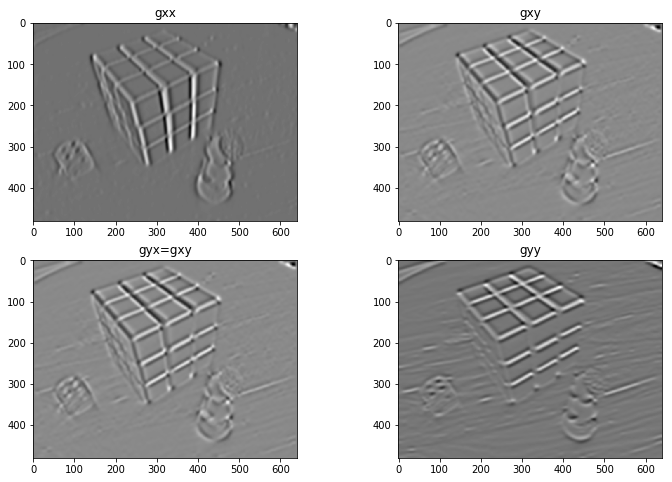

In [19]:
gx,gy = grad(cv.GaussianBlur(g,(0,0),4))

gxx,gxy = grad(gx)
gyx,gyy = grad(gy)

fig(12,8)
plt.subplot(2,2,1); imshowg(gxx); plt.title('gxx')
plt.subplot(2,2,2); imshowg(gxy); plt.title('gxy')
plt.subplot(2,2,3); imshowg(gyx); plt.title('gyx=gxy')
plt.subplot(2,2,4); imshowg(gyy); plt.title('gyy');

Con ellas conseguimos dos operadores importantes: Laplaciano y Hessiano:

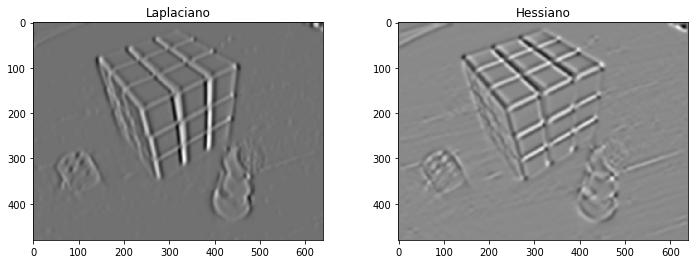

In [20]:
L = gxx+gyy
H = gxx*gyy-gxy**2

fig(12,4)
plt.subplot(1,2,1); imshowg(gxx); plt.title('Laplaciano')
plt.subplot(1,2,2); imshowg(gxy); plt.title('Hessiano');

Estos operadores se utilizarán más adelante para describir localmente la estructura de la imagen.

## Operador de Marr–Hildreth

Extendiendo el razonamiento anterior al caso de 2 dimensiones llegamos a un primer método de detección de bordes ([Marr-Hildreth](http://rspb.royalsocietypublishing.org/content/207/1167/187)). Se basa en encontrar los cruces por cero del Laplaciano de la imagen, previamente suavizada con un filtro gaussiano.

In [21]:
# ejemplo

Las operaciones de suavizado gaussiano y Laplaciano se pueden realizar simultaneamente con el operador $LoG(\sigma)$ que tiene forma de [sombrero mexicano](https://en.wikipedia.org/wiki/Mexican_hat_wavelet) invertido. Su efecto puede aproximarse bien mediante la diferencia de dos suavizados gaussianos ([DoG](https://en.wikipedia.org/wiki/Difference_of_Gaussians)), que normalmente se calculan eficientemente en una cascada.

## Operador de Canny

Es el [método estándar](https://en.wikipedia.org/wiki/Canny_edge_detector) de detección precisa de bordes. Busca los máximos locales del módulo del gradiente *en la dirección* del gradiente. Los bordes más intensos se seleccionan mediante un *umbralizado con histéresis* para conseguir secuencias continuas.

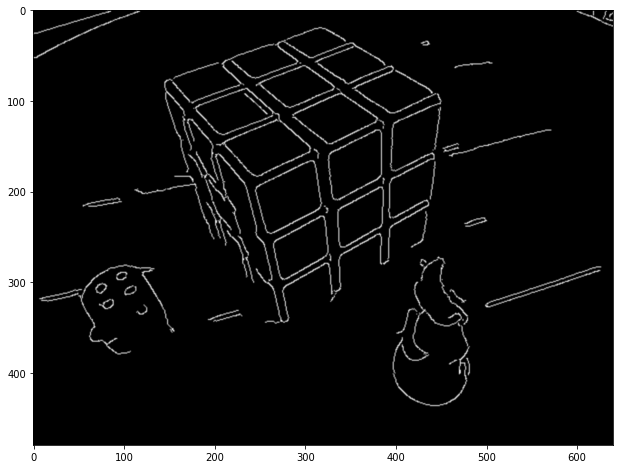

In [22]:
edges = cv.Canny(cv.GaussianBlur(g,(0,0),2).astype(np.uint8),20,60)

fig(12,8)
plt.imshow(edges, 'gray', interpolation='bicubic');

Los puntos de borde detectados se pueden extraer como secuencias de puntos.

**Ejercicio**: Escribe una implementación sencilla de la etapa de *supresión de no máximos* del método de Canny, preferiblemente usando operaciones vectorizadas de numpy.

### Información en los bordes

Casi toda la información de la imagen está en los puntos de borde. El resto es uniforme y se podría deducir.

Se puede reconstruir una versión aceptable de la imagen mediante "[inpainting](ipmisc.ipynb)" de los bordes de Canny. Los ensanchamos un poco con una [operación morfológica](http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html#gsc.tab=0) de dilatación para que haya información de color más o menos definida a cada lado.

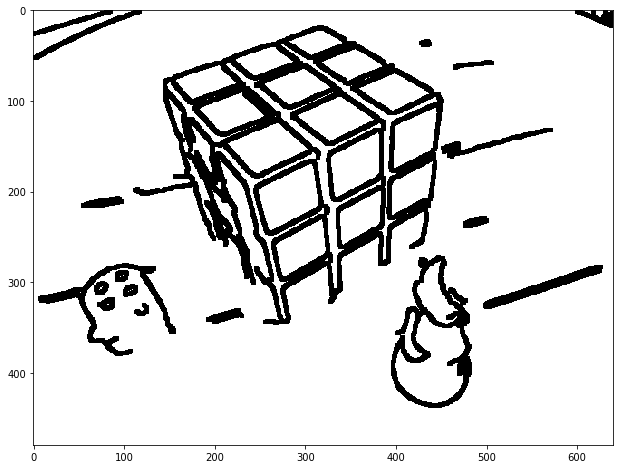

In [23]:
ker = np.ones((5,5),np.uint8)

#mask = 255-edges
mask = 255-cv.dilate(edges, ker)
fig(12,8)
imshowg(mask)

In [24]:
m3 = (255-mask).reshape(480,640,1).astype(bool)
xx = np.zeros([480,640,3],dtype=np.uint8)
np.copyto(xx, img, where = m3)

dst = cv.inpaint(img,mask,3,cv.INPAINT_NS);

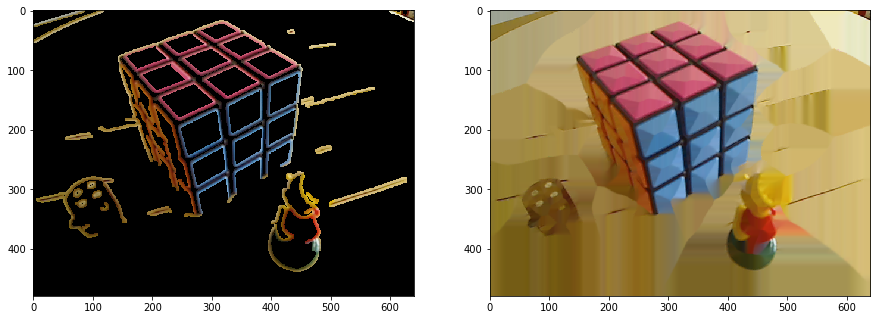

In [25]:
fig(15,6)
plt.subplot(1,2,1); plt.imshow(xx);
plt.subplot(1,2,2); plt.imshow(dst);

## Segmentos de recta

En algunas aplicaciones nos gustaría detectar bordes rectos. Una forma de conseguirlo es la [Transformada de Hough](https://en.wikipedia.org/wiki/Hough_transform). La idea es construir un espacio discretizado de los parámetros de todas las posibles rectas y cada punto de borde vota en todas las rectas que pasan por él.

Partimos de los bordes de Canny (o de cualquier otro filtro de alta frecuencia).

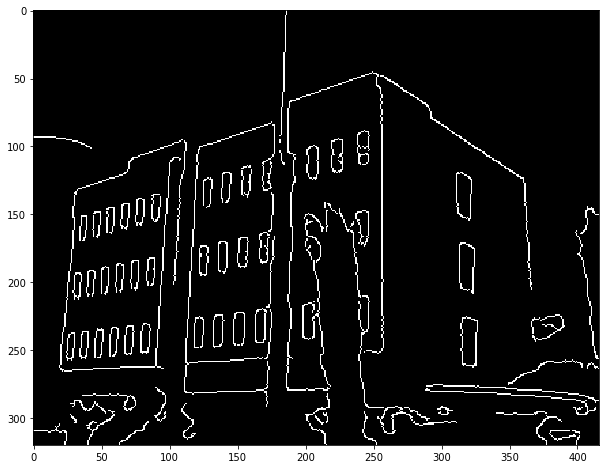

In [26]:
img = readrgb('pano/pano000.jpg')
g = cv.GaussianBlur(rgb2gray(img),(0,0),2)

edges = cv.Canny(g,20,80)
fig(12,8)
imshowg(edges)

Mostramos el resultado de la implementación disponible en scikit-image. (La versión de OpenCV es menos cómoda de utilizar.)

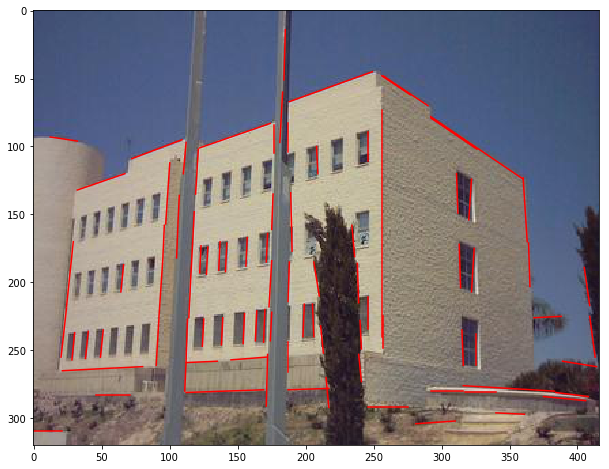

In [27]:
lines = probabilistic_hough_line(edges, 
                                 threshold=10, 
                                 line_length=20,
                                 line_gap=3)
fig(12,8)
plt.imshow(img)
ax = plt.axis()

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]),'r')

plt.axis(ax);

La técnica puede extenderse a estructuras geométricas más complejas como círculos, polígonos, etc. usando un espacio de parámetros de más dimensiones.

## Histograma de orientaciones de gradiente (HOG)

Hemos visto que la distribución (histograma) de colores es una característica que permite distinguir algunos tipos de objetos, siempre que sean de colores muy distintos y las condiciones de iluminación no cambien mucho.

De forma parecida, la distribución de los vectores de gradiente permite caracterizar el aspecto de objetos rígidos o que sufren deformaciones pequeñas. Para que esto sea efectivo es necesario calcular varios **histogramas locales** en una malla que cubre la región de interés (no un único histograma de toda ella).  Y, lo que es más importante, el histograma debe hacerse sobre las **orientaciones** del gradiente (ángulos discretizados). En cada celda se contabiliza la magnitud total de gradiente que hay en cada orientación.

Esta operación se conoce como [HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) ([Dalal & Triggs, 2005](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)) y es una de las técnicas más utilizadas para la detección de objetos semirígidos como  peatones, caras, vehículos, etc.

### Implementación simple

Vamos a calcular manualmente un histograma de orientaciones de gradiente con operaciones de numpy.

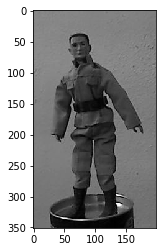

In [28]:
x = rgb2gray(readrgb('madelman.png'))
imshowg(x);

Ampliamos mucho los pixels y mostramos el nivel de gris de cada uno:

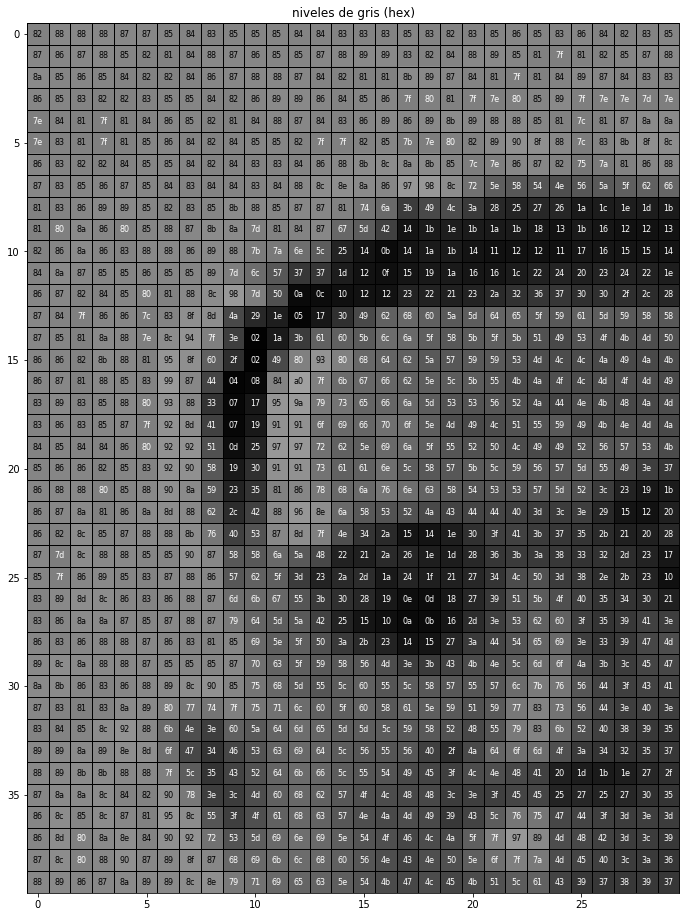

In [29]:
trozo = x[30:70, 50:80]
h,w = trozo.shape
fig(16,16)
plt.imshow(trozo,'gray',vmin=0,vmax=255)
for j in range(w):
    plt.hlines(np.arange(h)-0.5,-0.5,w,lw=0.5)
for i in range(h):
    plt.vlines(np.arange(w)-0.5,-0.5,h,lw=0.5)
    for j in range(w):
        plt.text(j,i,'{:02x}'.format(trozo[i,j]),color='black' if trozo[i,j] > 128 else 'white',
                 horizontalalignment='center',verticalalignment='center',fontsize=8);
plt.xlim(-0.5,w-0.5); plt.ylim(h-0.5,-0.5);
plt.title('niveles de gris (hex)');

Mostramos el gradiente en un fragmento:

In [30]:
trozo = x[35:55, 55:80]
gx = cv.Sobel(trozo,cv.CV_16S,1,0) //8
gy = cv.Sobel(trozo,cv.CV_16S,0,1) //8
gm = np.sqrt(gx**2+gy**2).astype(int)
ga = np.arctan2(gy,gx)

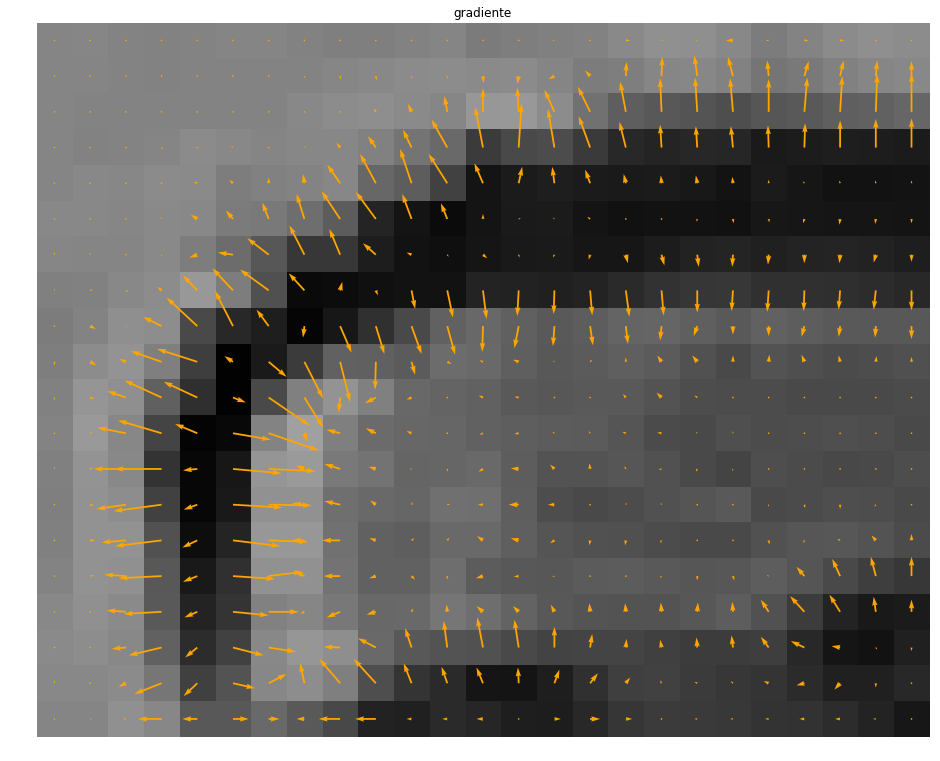

In [31]:
x,y = dom(trozo.shape)

r1 = y
c1 = x
r2 = -gy[r1,c1]   # filas = - eje Y
c2 =  gx[r1,c1]

fig(16,14)
plt.imshow(trozo,'gray',vmin=0,vmax=255)
#plt.imshow(gx,'coolwarm',vmin=-128,vmax=128)

plt.quiver(c1, r1, c2, r2, color='orange', width=0.002, scale=50, scale_units='xy');

h,w = trozo.shape
if False:
    for j in range(w):
        plt.hlines(np.arange(h)-0.5,-0.5,w,lw=0.5)
    for i in range(h):
        plt.vlines(np.arange(w)-0.5,-0.5,h,lw=0.5)
    
plt.xlim(-0.5,w-0.5); plt.ylim(h-0.5,-0.5);
plt.title('gradiente'); plt.axis('off');

Reducimos el ángulo a 4 direcciones: 0-- 1/  2| 3\ . (La forma hacerlo se explica en el notebook [cannyC](cannyC.ipynb).)

In [32]:
gad = (np.round(ga / np.pi * 4) % 4).astype(np.uint8)

Mostramos en cada píxel la magitud del gradiente precedido del código de orientación (solo donde el gradiente es aprecible):

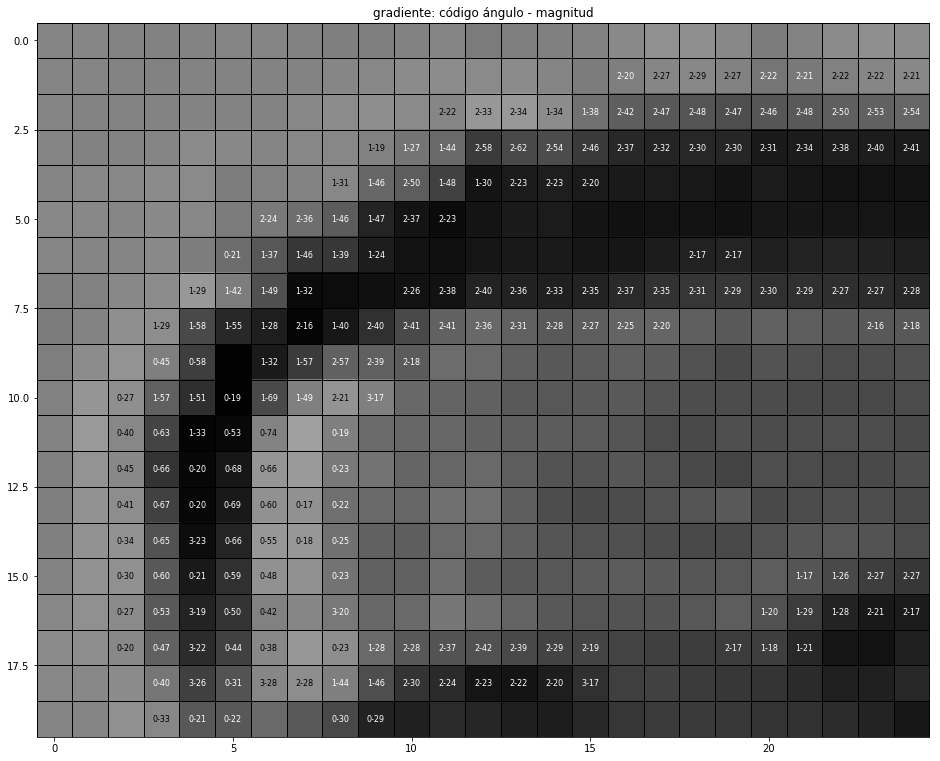

In [33]:
fig(16,14)
plt.imshow(trozo,'gray',vmin=0,vmax=255)
#plt.imshow(gx,'coolwarm',vmin=-128,vmax=128)
h,w = trozo.shape
for j in range(w):
    plt.hlines(np.arange(h)-0.5,-0.5,w,lw=0.5)
for i in range(h):
    plt.vlines(np.arange(w)-0.5,-0.5,h,lw=0.5)
    for j in range(w):
        if gm[i,j]> 15:
            plt.text(j,i,'{}-{}'.format(gad[i,j], gm[i,j]),color='black' if trozo[i,j] > 128 else 'white',
                     horizontalalignment='center',verticalalignment='center',fontsize=8);
plt.xlim(-0.5,w-0.5); plt.ylim(h-0.5,-0.5);
plt.title('gradiente: código ángulo - magnitud');

Es mejor visualizar la esta información con líneas que indican la intensidad de borde:

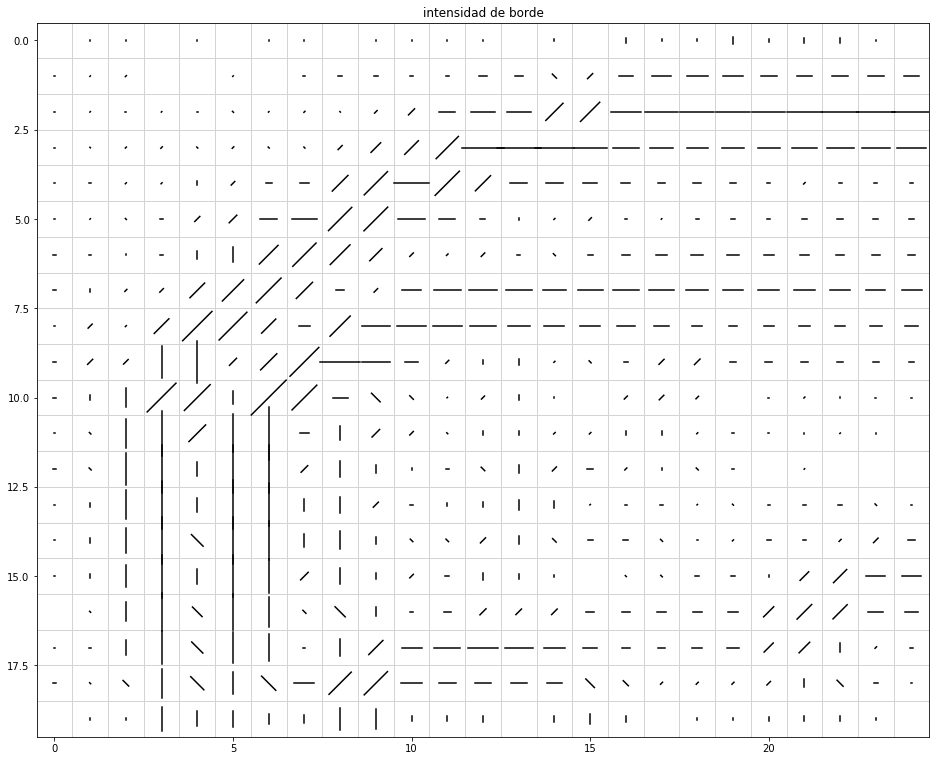

In [34]:
dx = np.cos(np.radians([90,135,0,45]))
dy = np.sin(np.radians([90,135,0,45]))

def edge(x,y,g,a):
    plt.plot([x-g*dx[a],x+g*dx[a]],[y-g*dy[a],y+g*dy[a]],color='black')


fig(16,14)
plt.imshow(255-trozo*0,'gray',vmin=0,vmax=255)
#plt.imshow(gx,'coolwarm',vmin=-128,vmax=128)
h,w = trozo.shape
for j in range(w):
    plt.hlines(np.arange(h)-0.5,-0.5,w,lw=0.5,color='lightgray')
for i in range(h):
    plt.vlines(np.arange(w)-0.5,-0.5,h,lw=0.5,color='lightgray')
    for j in range(w):
        edge(j,i,gm[i,j]/100,gad[i,j])
plt.xlim(-0.5,w-0.5); plt.ylim(h-0.5,-0.5);
plt.title('intensidad de borde'); #plt.axis('off');

Calculamos el histograma de esas cuatro direcciones:

In [35]:
np.histogram(gad,bins=[0,1,2,3,4])

(array([142, 113, 207,  38]), array([0, 1, 2, 3, 4]))

Es lo mismo que

In [36]:
[np.sum(gad==x) for x in range(4)]

[142, 113, 207, 38]

Pero lo que realmente nos interesa es contabilizar la cantidad total de intensidad en cada orientación (no el mismo valor de 1 en cada pixel, independientemente de la intensidad del gradiente).

In [37]:
[np.sum(gm[gad==x]) for x in range(4)]

[2479, 1951, 3658, 301]

Esta operación es un histograma con pesos:

In [38]:
np.histogram(gad, weights=gm, bins=[0,1,2,3,4])

(array([2479, 1951, 3658,  301]), array([0, 1, 2, 3, 4]))

Es preferible normalizar el histograma:

In [39]:
feature = np.histogram(gad, bins=[0,1,2,3,4], weights=gm, density=True)[0]
feature

array([ 0.29550602,  0.23256646,  0.4360472 ,  0.03588032])

En esta región la dirección 2 es la más frecuente (gradiente vertical, borde horizontal), seguida de la 0 y la 1. Hay muy pocas orientaciones tipo 3. El histograma se puede representar gráficamente así:

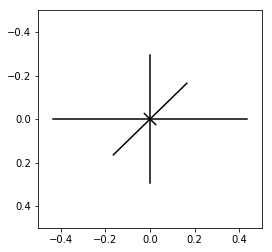

In [40]:
fig(4,4)
ax = plt.axis([-0.5,0.5,0.5,-0.5]);
for v,c in zip(feature, range(4)):
    edge(0,0,v,c)

Las imágenes se particionan en celdas (de tamaño 16x16, por ejemplo) y en cada una de ellas se calcula el histograma de orientaciones.

En la práctica es conveniente agrupar las celdas en bloques (de tamaño 2x2, por ejemplo) para normalizar los histogramas de cada celda teniendo en cuenta un contexto más amplio. Los bloques están solapados y por tanto cada celda contribuye a varios bloques con diferente normalización.

### HOG en OpenCV y scikit-learn

Podemos calcular los histogramas de orientaciones de gradiente con OpenCV, pero scikit-image proporciona también una representación visual de los histogramas muy informativa:

(351, 198) (42, 23, 2, 2, 8)


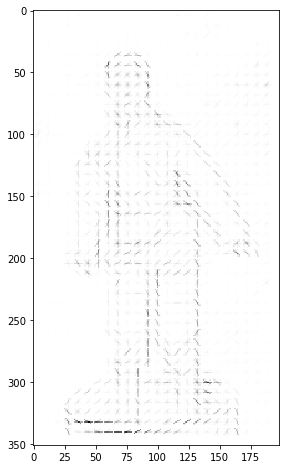

In [41]:
from skimage.feature import hog

x = rgb2gray(readrgb('madelman.png'))

v,sh = hog(x, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2),
              visualise=True, transform_sqrt=True, feature_vector=False, block_norm='L2-Hys')

print(x.shape, v.shape)

fig(12,8)
imshowg(255-sh);

Para intentar encontrar este objeto en otra imagen calculamos este tipo de histograma de bordes sobre la imagen completa y comparamos con el HOG del modelo en todas las posiciones mediante una "sliding window". La detección del objeto de cualquier tamaño se hace repitiendo el proceso sobre una "pirámide" de escalas (una secuencia de imágenes progresivamente más pequeñas).

En el laboratorio implementaremos una versión básica de esta idea comparando los HOG mediante una distancia simple ([`hog0.py`](../code/hog/hog0.py)). Para conseguir resultados más precisos hay que recurrir a técnicas de *machine learning* más potentes.
El ejemplo de código [`pedestrian.py`](../code/hog/pedestrian.py)  muestra cómo utilizar un clasificador de personas preentrenado que incluye OpenCV, basado en HOG y [SVM](https://en.wikipedia.org/wiki/Support_vector_machine) ([blog post](http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/)).

El ejemplo [`facelandmarks.py`](../code/hog/facelandmarks.py) muestra el funcionamiento del detector de caras basado en HOG disponible en la biblioteca [dlib](http://dlib.net/), que también incluye un detector de marcadores faciales.

Esta biblioteca incluye también una herramienta para etiquetar ejemplos en imágenes de entrenamiento y validación, y código para entrenar un clasificador.